# an example about loading data from tfrecord

[https://www.tensorflow.org/tutorials/using_gpu](using gpu)

In [1]:
%pylab inline
import tensorflow as tf
import pandas as pd
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 320

Populating the interactive namespace from numpy and matplotlib


In [4]:
val_filename = '/notebooks/Minecraft-AI/mc-data/mesa_3_vs_forest_1_test.tfrecords'

In [5]:
labels ={0:"desert",1:"forest",2:"jungle", 3: "mesa",4:"eh"}
tfrecords_filename = '/notebooks/Minecraft-AI/mc-data/mesa_3_vs_forest_1_train.tfrecords'


In [3]:

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    label =  tf.cast(features['label'], tf.int32)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    #tf.stack equal to tf.stack([x, y, z]) = np.asarray([x, y, z])
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations,label = tf.train.shuffle_batch( [resized_image, resized_annotation,label],
                                                 batch_size=10,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations, label, width, height

In [6]:
def scaleImg(img):
    scaled_img = img.astype(numpy.float32)
    return scaled_img /255

Tensor("shuffle_batch:2", shape=(10,), dtype=int32)
(200, 320, 3)
current batch
(200, 320, 3)
current batch
(200, 320, 3)
current batch


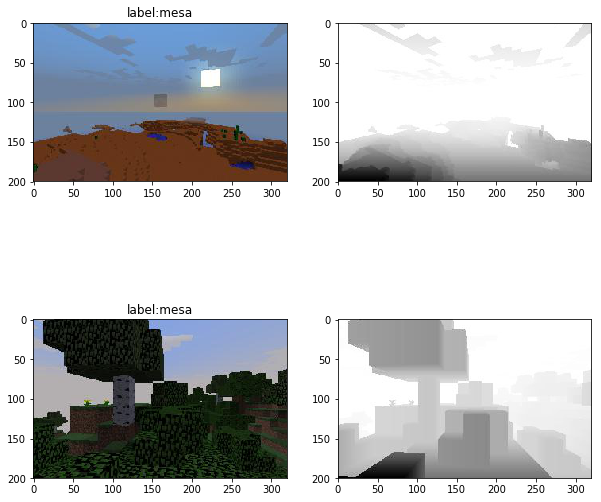

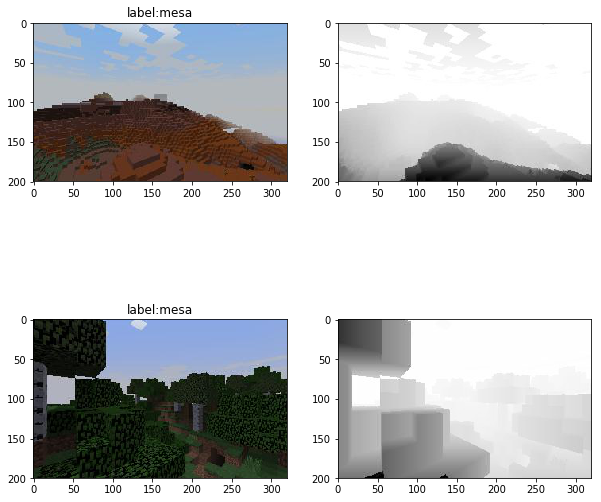

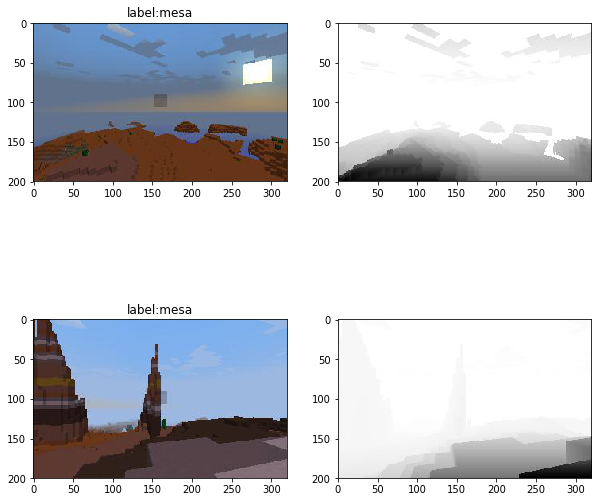

In [7]:

#this is for validation data
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename])

# Even when reading in multiple threads, share the filename
# queue.
image, annotation, label, w, h = read_and_decode(filename_queue)
print(label)
# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(3):
        fig = plt.figure(figsize=(10,10))
        img, anno, lab = sess.run([image, annotation, label])
       # images = np.multiply(img, 1.0 / 255.0)
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random
#         print "label:", labels[lab[0]]
#         print lab
        
        fig.add_subplot(221)
        plt.title("label:{}".format(labels[lab[0]]))
        plt.imshow(scaleImg(img[0,:,:,:]))
        fig.add_subplot(222)
        plt.imshow(scaleImg(anno[0, :, :, 0]),cmap=plt.cm.Greys)

        fig.add_subplot(223)
        plt.title("label:{}".format(labels[lab[0]]))
        plt.imshow(scaleImg(img[1,:,:,:]))

        fig.add_subplot(224)
        plt.imshow(scaleImg(anno[1, :, :, 0]),cmap=plt.cm.Greys)
    
    coord.request_stop()
    coord.join(threads)